In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [2]:
BASE_PATH = '../input/coco-2017-dataset/coco2017'

In [3]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.head()

image  \
0  ../input/coco-2017-dataset/coco2017/train2017/...   
1  ../input/coco-2017-dataset/coco2017/train2017/...   
2  ../input/coco-2017-dataset/coco2017/train2017/...   
3  ../input/coco-2017-dataset/coco2017/train2017/...   
4  ../input/coco-2017-dataset/coco2017/train2017/...   

                                             caption  
0  A yellow motorcycle parked while someone stand...  
1        A giraffe laying down in the dirt at a zoo.  
2  A skateboarder performing a trick on a ramp wh...  
3         A surfer is waiting for the next big wave.  
4       People are skiing down a snow covered hill.

In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # removal of punctuations
    text = re.sub('\s+', ' ', text) # converting multiple whitespaces to 1 whitespace
    text = text.strip() # strip trailing whitespaces
    text = '[start] ' + text + ' [end]' # adding start and end tokens
    return text

In [5]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

image  \
0  ../input/coco-2017-dataset/coco2017/train2017/...   
1  ../input/coco-2017-dataset/coco2017/train2017/...   
2  ../input/coco-2017-dataset/coco2017/train2017/...   
3  ../input/coco-2017-dataset/coco2017/train2017/...   
4  ../input/coco-2017-dataset/coco2017/train2017/...   

                                             caption  
0  [start] a yellow motorcycle parked while someo...  
1  [start] a giraffe laying down in the dirt at a...  
2  [start] a skateboarder performing a trick on a...  
3  [start] a surfer is waiting for the next big w...  
4  [start] people are skiing down a snow covered ...

[start] a train under some wires at a train station [end]



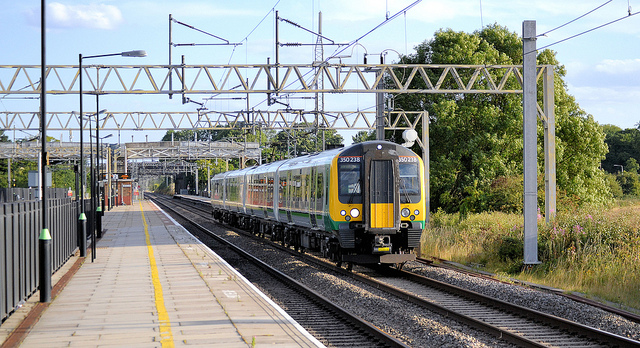

In [6]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [7]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 15000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 15

In [8]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [9]:
tokenizer.vocabulary_size()

11799

In [10]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))
# saving the vocabulary of the tokenizer to the vocab_coco file

In [11]:
# maps words to their corresponding indices in their vocabulary
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

# maps indices back to their corresponding words
idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [12]:
# img_path : captions
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

# splitting into training and validation sets
train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [13]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(56036, 56036, 13964, 13964)

In [14]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    
    # pre-processes the image according to the requirements of the Inception v3 model
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [15]:
# creating a dataset from the tensor slices
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

# applies the load_data() function to each element in the dataset
# AUTOTUNE => allows TensorFlow to automatically determine the no. of parallel cells
# shuffling and batching is done (into BATCH_SIZE no. of batches)
train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
# img augmentation pipeline
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"), # randomly flips imgs horizontally with a probability of 0.5
        tf.keras.layers.RandomRotation(0.2), # randomly rotates img by a maximum angle of 0.2 radians
        tf.keras.layers.RandomContrast(0.3), # randomly adjusts contrast of the img in the interval of [1-0.3, 1+0.3] radians
    ]
)

In [17]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False, # the fully connected layers are excluded
        weights='imagenet' # InceptionV3 pre-trained on ImageNet dataset
    )

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output) # reshaping into a 3D tensor

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [18]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        # 2 layers which normalize their activations are used
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization() 
        # 1 multi-head attention layer with the previously specified no. of attention heads and dimensionality is used
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        
        # a feed-forward NN transformation is applied to the input embeddings with the ReLU activation function
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [19]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        # embedding layer for token embeddings
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        
        # embedding layer for positional embeddings
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [20]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        
        # 1st embeddings is created
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        # 2 multi-head attention layers are added
        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        # 3 normalized layers are added
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        # 2 Feed-Forward NN layers are added
        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        # final putput layer with softmax activation function => because output is the generated caption which can belong to multiple classes
        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        # 2 dropout layers
        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        # applying the masks
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        # applying 1st attention layer
        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )
        
        # 1st layer => attention output + input embedding thats normalized
        out_1 = self.layernorm_1(embeddings + attn_output_1)

        # applying 2nd attention layer
        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        # 2nd layer => attention output + input embedding thats normalized
        out_2 = self.layernorm_2(out_1 + attn_output_2)

        # feed forward NN + dropouts
        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)
        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    # generates causal_attention_mask so that each token attends only to previous tokens in the sequence during self-attention
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [21]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        
        # calculates gradient
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        
        # updates model parameters via back propagation
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [22]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87924736/87910968 [==============================] - 1s 0us/step


In [23]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# early stopping stops training if metrics dont improve significantly after a certain no. of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# compiles the img captioning model with adam optimizer and the loss function
caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [24]:
# training the img captioning model
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/15
876/876 [==============================] - 545s 605ms/step - loss: 4.1771 - acc: 0.2603 - val_loss: 3.4863 - val_acc: 0.3803
Epoch 2/15
876/876 [==============================] - 442s 503ms/step - loss: 3.2837 - acc: 0.3892 - val_loss: 3.2180 - val_acc: 0.4080
Epoch 3/15
876/876 [==============================] - 446s 507ms/step - loss: 3.0391 - acc: 0.4157 - val_loss: 3.1262 - val_acc: 0.4176
Epoch 4/15
876/876 [==============================] - 446s 506ms/step - loss: 2.9028 - acc: 0.4294 - val_loss: 3.0877 - val_acc: 0.4241
Epoch 5/15
876/876 [==============================] - 442s 502ms/step - loss: 2.7989 - acc: 0.4390 - val_loss: 3.0659 - val_acc: 0.4259
Epoch 6/15
876/876 [==============================] - 444s 505ms/step - loss: 2.7126 - acc: 0.4468 - val_loss: 3.0762 - val_acc: 0.4293
Epoch 7/15
876/876 [==============================] - 447s 509ms/step - loss: 2.6431 - acc: 0.4540 - val_loss: 3.0764 - val_acc: 0.4298
Epoch 8/15
876/876 [============================

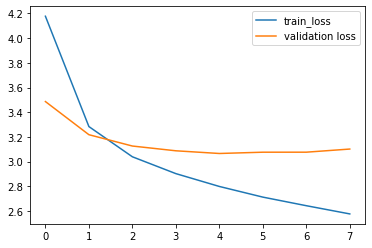

In [25]:
# plotting the training vs validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [26]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Predicted Caption: a group of people standing in a field with a frisbee



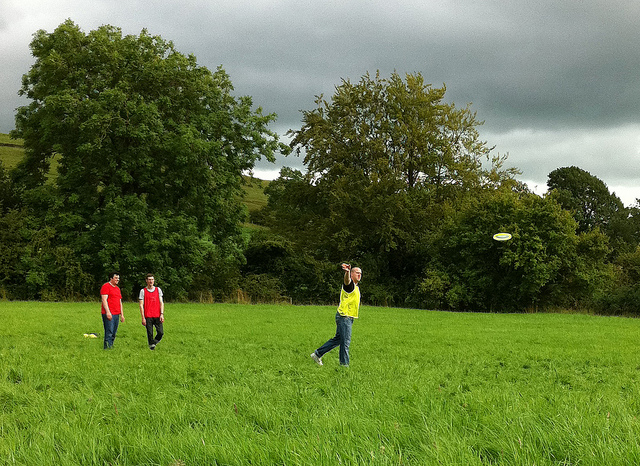

In [44]:
# selects a random image path from the captions df and generates a caption for that img
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

Predicted Caption: a boat is in the water with a boat on it



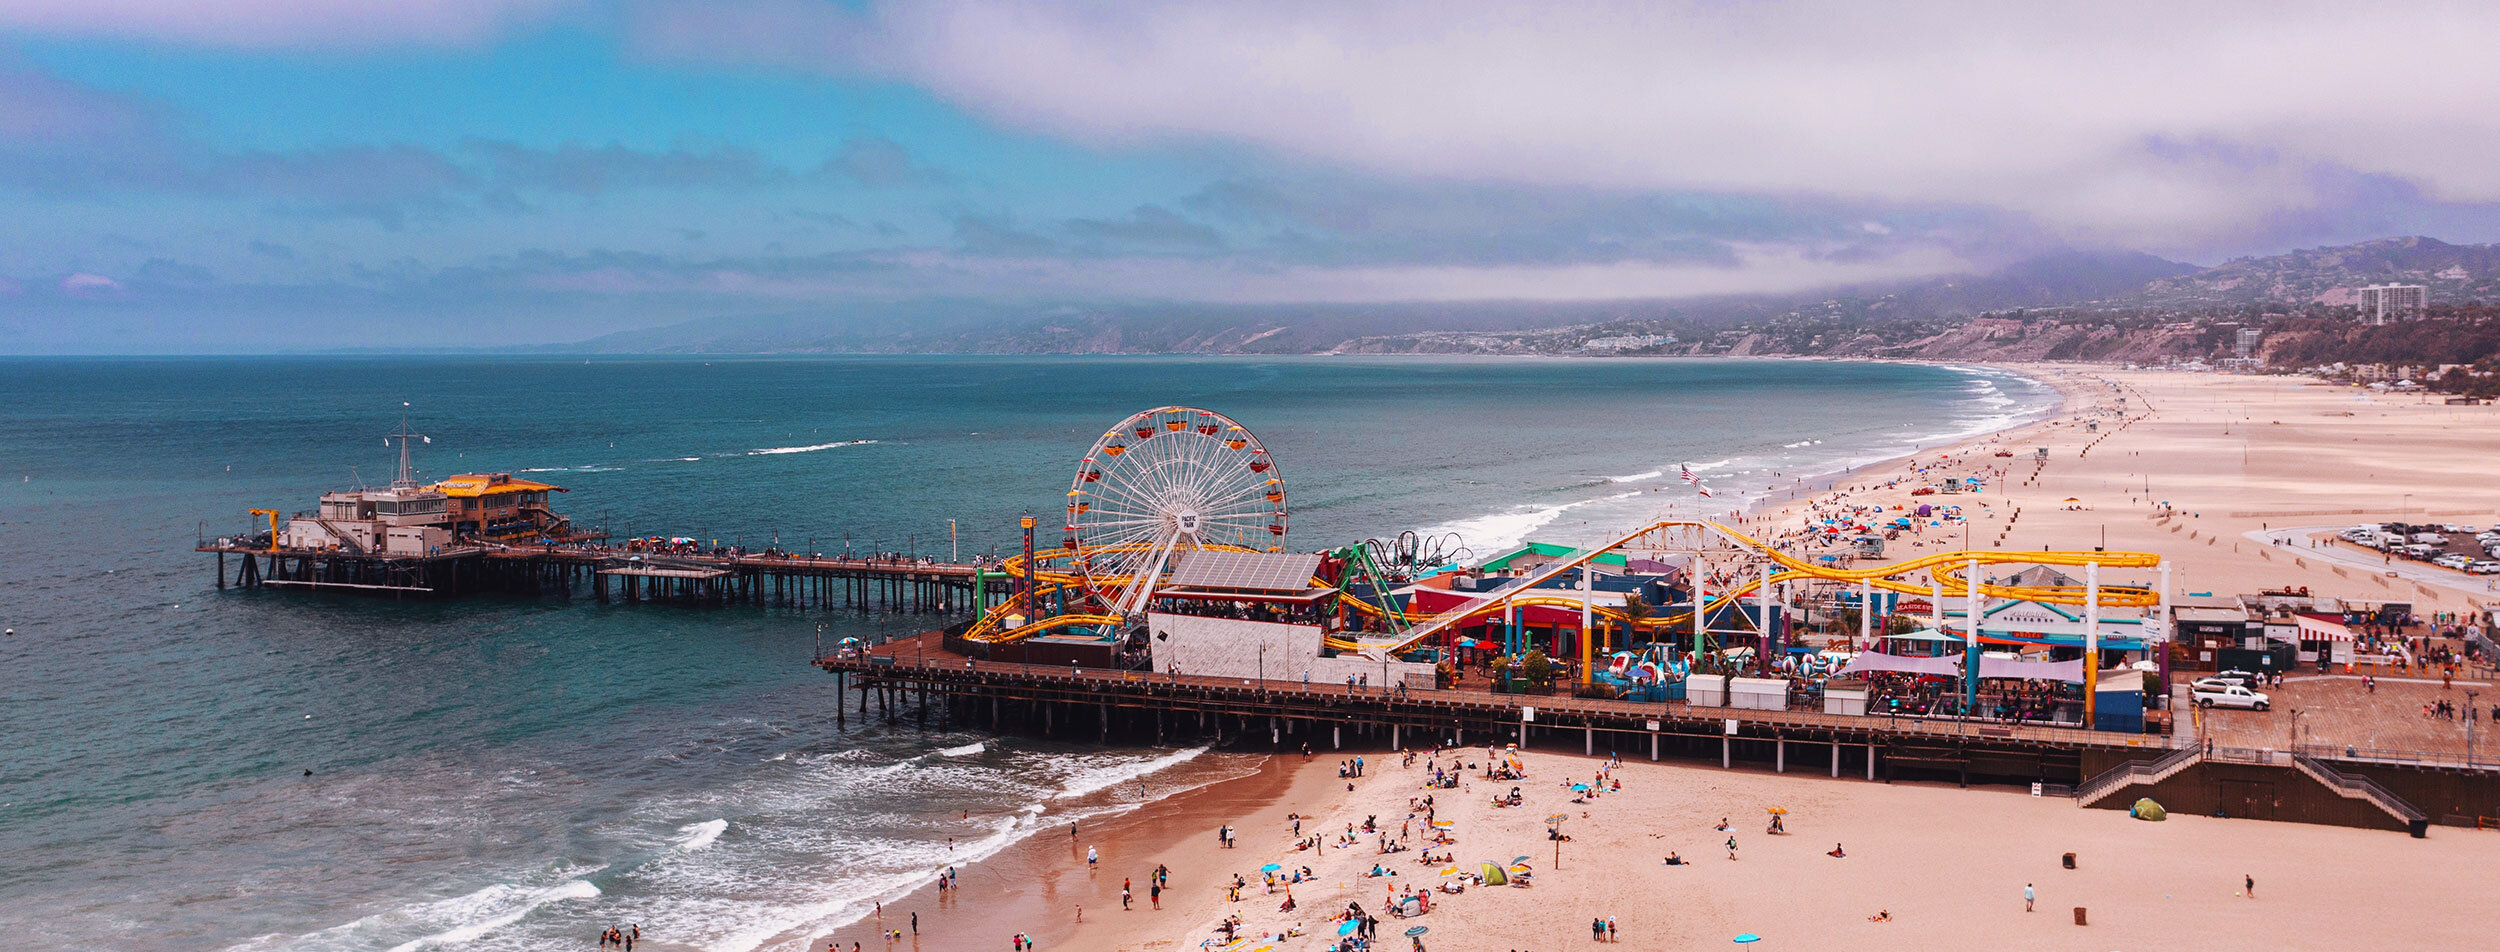

In [28]:
img_url = "https://images.squarespace-cdn.com/content/v1/5e0e65adcd39ed279a0402fd/1627422658456-7QKPXTNQ34W2OMBTESCJ/1.jpg?format=2500w"

im = Image.open(requests.get(img_url, stream=True).raw)
im = im.convert('RGB')
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg', add_noise=False)
print('Predicted Caption:', pred_caption)
print()
im

In [29]:
caption_model.save_weights('model.h5')